mark to standard deviations
AND figure out why volatility trends downward as options price increases by delta. 

Screener filter ideas: 
1. price * volume > 600M
2. roc over a period >0
3. SMA for period or moving rate of change positive trending 
4. low implied volatility 
5. good near expiry options volume 
6. near expiry decreasing volatility
Other ideas: Neural network for buy/sell? 

In [81]:
import pandas as pd 
import numpy as np 
import os
import pandas as pd

desktop_path = os.path.join(os.path.expanduser("~"), "Desktop", "datafix.csv")
datafix = pd.read_csv(desktop_path)


In [82]:
datafix = datafix.set_index("Date")


In [83]:
import matplotlib.pyplot as plt
def plot(name):
    column_to_plot = name  # Replace with your actual column name

    if column_to_plot in datafix.columns:
     datafix[column_to_plot].plot(kind='line', title=f"{column_to_plot} Chart")
     plt.xlabel("Index")
     plt.ylabel(column_to_plot)
     plt.show()
    else:
        print(f"Column '{column_to_plot}' not found in datafix DataFrame.")


In [84]:
import numpy as np

# Standardize MACD_Hist using a rolling window (e.g., 50 periods)
window = 20
datafix["MACD_Hist_std"] = (
    (datafix["MACD_Hist"] - datafix["MACD_Hist"].rolling(window).mean()) /
    datafix["MACD_Hist"].rolling(window).std()
)



In [85]:
import numpy as np
from hmmlearn.hmm import GaussianHMM

# Assume 'Kalman_Roc' is already in datafix and contains the filtered returns
# Drop NaN values to ensure clean input for the HMM
kalman_roc_values = datafix['Kalman_Roc'].dropna().values.reshape(-1, 1)

# Fit a 2-state Gaussian HMM
hmm_model = GaussianHMM(n_components=2, covariance_type='full', n_iter=1000)
hmm_model.fit(kalman_roc_values)

# Predict the hidden states (regimes)
hidden_states = hmm_model.predict(kalman_roc_values)

# Align the states with the original dataframe
states_full = np.full(len(datafix), np.nan)
states_full[datafix['Kalman_Roc'].notna()] = hidden_states

# Append the regime state to the dataframe
datafix['regime_state'] = states_full


In [86]:
from arch import arch_model

# Drop NaN values from 'IV' for modeling
iv_series = datafix['IV'].dropna()

# Fit a GARCH(1,1) model to the IV series
model = arch_model(iv_series, mean='Zero', vol='GARCH', p=1, q=1)
model_fit = model.fit(disp='off')

# Get the conditional variance (volatility estimate) for each point
conditional_variance = model_fit.conditional_volatility

# Align the conditional volatility with the original dataframe's index
# This will fill NaN for rows where 'IV' was NaN
datafix['IV_garch_vol'] = conditional_variance.reindex(datafix.index)
datafix["GarchRoc"] = datafix['IV_garch_vol'].pct_change()
datafix["GarchRoc5sma"] = datafix["GarchRoc"].rolling(3).mean()
datafix["GarchSma"] = datafix['IV_garch_vol'].rolling(14).mean()
datafix["GarchSmaSpread"] = datafix['IV_garch_vol']-datafix["GarchSma"]
datafix["regimecount"]= datafix["regime_state"].rolling(14).sum()
from sklearn.preprocessing import StandardScaler

# Reshape the data for the scaler
spread_values = datafix['GarchSmaSpread'].values.reshape(-1, 1)

# Initialize and fit the scaler
scaler = StandardScaler()
standardized_spread = scaler.fit_transform(spread_values)

# Add the standardized spread back to the dataframe
datafix['GarchSmaSpread_std'] = standardized_spread
from sklearn.preprocessing import StandardScaler

# Reshape the data for the scaler
garchroc5sma_values = datafix['GarchRoc5sma'].values.reshape(-1, 1)

# Initialize and fit the scaler
scaler_roc5sma = StandardScaler()
standardized_roc5sma = scaler_roc5sma.fit_transform(garchroc5sma_values)

# Add the standardized GarchRoc5sma back to the dataframe
datafix['GarchRocsma_std'] = standardized_roc5sma
from sklearn.preprocessing import StandardScaler

# Reshape the data for the scaler
garchroc_values = datafix['GarchRoc'].values.reshape(-1, 1)

# Initialize and fit the scaler
scaler_garchroc = StandardScaler()
standardized_garchroc = scaler_garchroc.fit_transform(garchroc_values)

# Add the standardized GarchRoc back to the dataframe
datafix['GarchRoc_std'] = standardized_garchroc


/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002931. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [87]:
import pandas as pd

def compute_rsi(df, column="Close", period=14):
    # Calculate price differences
    delta = df[column].diff()
    # Separate gains and losses
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    # Calculate exponential moving averages of gains and losses
    avg_gain = gain.ewm(alpha=1/period, min_periods=period, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/period, min_periods=period, adjust=False).mean()
    # Calculate RS and RSI
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    # Add RSI to dataframe
    df['RSI'] = rsi
    return df

compute_rsi(datafix)
# Calculate 14-period moving average of the 'Close' column
datafix['rsiMA_14'] = datafix['RSI'].rolling(window=14).mean()



In [88]:
datafix

,Open,High,Low,Close,Volume,Kalman,Kalman_Roc,MACD,Signal,MACD_Hist,...,GarchRoc,GarchRoc5sma,GarchSma,GarchSmaSpread,regimecount,GarchSmaSpread_std,GarchRocsma_std,GarchRoc_std,RSI,rsiMA_14
Date,,,,,,,,,,,,,,,,,,,,,
2025-06-26 19:30:00,0.24,0.24,0.24,0.24,1,0.240000,NaN,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-06-26 19:35:00,0.24,0.24,0.24,0.24,1,0.240000,0.000000,0.000000,0.000000,0.000000,...,0.032706,NaN,NaN,NaN,NaN,NaN,NaN,1.231093,NaN,NaN
2025-06-26 19:40:00,0.25,0.25,0.25,0.25,1,0.248120,3.383141,0.000798,0.000160,0.000638,...,0.005793,NaN,NaN,NaN,NaN,NaN,NaN,0.186551,NaN,NaN
2025-06-27 13:40:00,0.26,0.30,0.26,0.30,3,0.285757,15.169284,0.005402,0.001208,0.004194,...,0.009614,0.016038,NaN,NaN,NaN,NaN,1.025877,0.334842,NaN,NaN
2025-06-27 13:50:00,0.29,0.29,0.28,0.28,2,0.289558,1.329912,0.007353,0.002437,0.004916,...,0.035498,0.016968,NaN,NaN,NaN,NaN,1.088939,1.339450,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-01 19:05:00,0.74,0.83,0.74,0.83,12,0.826370,1.505317,0.081671,0.094738,-0.013067,...,-0.016393,-0.011096,0.195067,-0.003627,0.0,-0.495274,-0.812780,-0.674545,56.955542,61.856534
2025-07-01 19:10:00,0.85,0.85,0.80,0.83,3,0.835451,1.098936,0.080639,0.091918,-0.011280,...,0.028817,0.009067,0.195072,0.001885,0.0,0.114463,0.553522,1.080134,56.955542,61.372139
2025-07-01 19:15:00,0.85,0.90,0.82,0.90,16,0.860550,3.004267,0.084495,0.090434,-0.005939,...,-0.015761,-0.001113,0.194967,-0.001115,0.0,-0.217342,-0.136295,-0.650021,59.773594,60.803890


In [89]:
#MACD IV
# Calculate MACD and Signal Line
def calculate_macd(df, close_col='IV_garch_vol', fast=12, slow=26, signal=9):
    ema_fast = df[close_col].ewm(span=fast, adjust=False).mean()
    ema_slow = df[close_col].ewm(span=slow, adjust=False).mean()
    macd = ema_fast - ema_slow
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    macd_hist = macd - signal_line
    df['MACDvol'] = macd
    df['Signalvol'] = signal_line
    df['MACD_Histvol'] = macd_hist
    return df

macdata = calculate_macd(datafix, close_col='IV_garch_vol', fast=12, slow=26, signal=9)

# Plotting MACD
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

# Split MACD histogram into positive and negative for color distinction
macd_hist = macdata['MACD_Histvol']
pos_hist = macd_hist.copy()
neg_hist = macd_hist.copy()
pos_hist[pos_hist < 0] = 0
neg_hist[neg_hist > 0] = 0

datafix['MACDROCvol'] = macdata['MACD_Histvol'].pct_change()

In [90]:
#MACD KALMAN
# Calculate MACD and Signal Line
def calculate_macd(df, close_col='Kalman', fast=12, slow=26, signal=9):
    ema_fast = df[close_col].ewm(span=fast, adjust=False).mean()
    ema_slow = df[close_col].ewm(span=slow, adjust=False).mean()
    macd = ema_fast - ema_slow
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    macd_hist = macd - signal_line
    df['MACDkalman'] = macd
    df['Signalkalman'] = signal_line
    df['MACD_Histkalman'] = macd_hist
    return df

macdata = calculate_macd(datafix, close_col='Kalman', fast=12, slow=26, signal=9)

# Plotting MACD
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

# Split MACD histogram into positive and negative for color distinction
macd_hist = macdata['MACD_Histkalman']
pos_hist = macd_hist.copy()
neg_hist = macd_hist.copy()
pos_hist[pos_hist < 0] = 0
neg_hist[neg_hist > 0] = 0
datafix['MACDROCkal'] = macdata['MACD_Histkalman'].pct_change()
datafix['MACDROC'] = macdata['MACD_Hist'].pct_change()
datafix['VolumeSMA9'] = datafix['Volume'].rolling(9).mean()
datafix['VolumeSMA26'] = datafix['Volume'].rolling(26).mean()

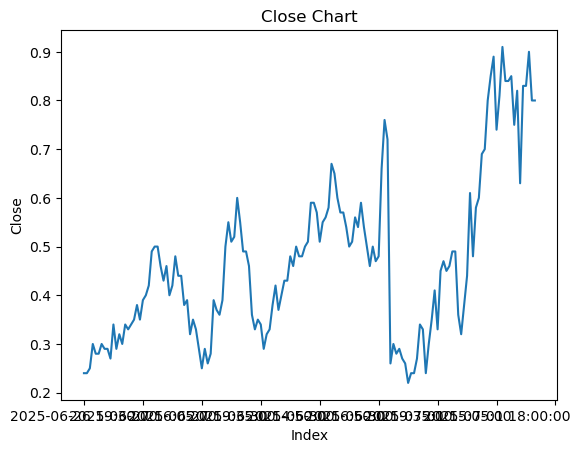

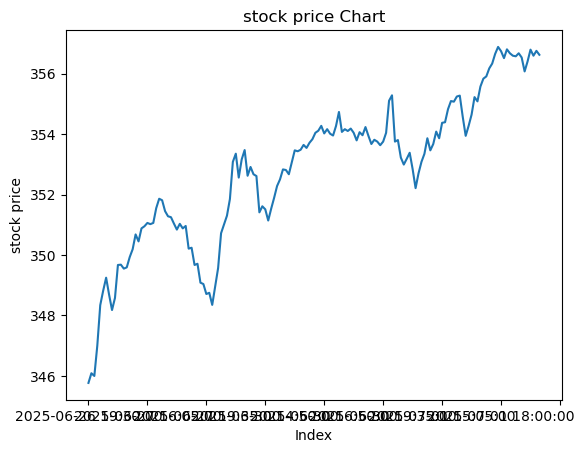

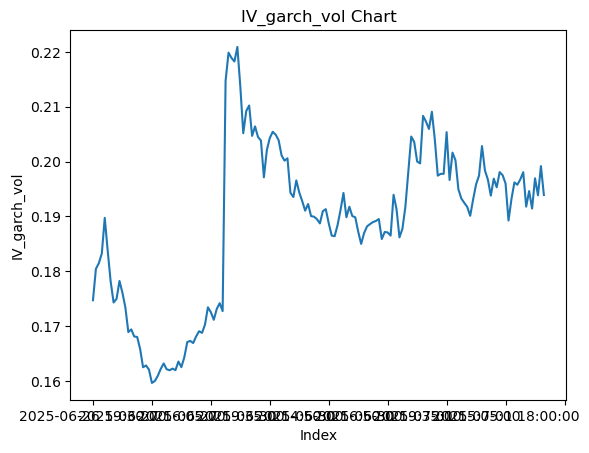

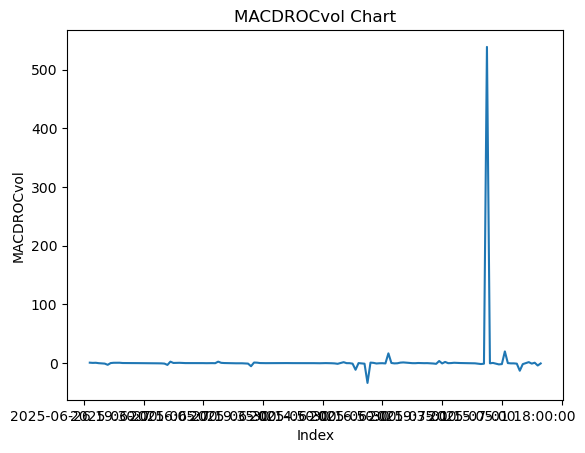

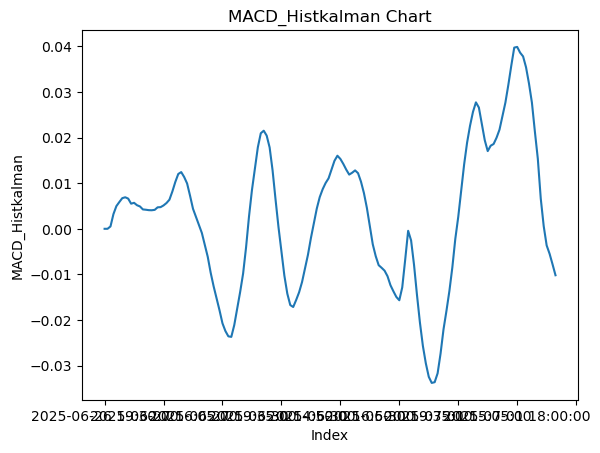

In [91]:
plot('Close')
plot('stock price')
plot('IV_garch_vol')
plot('MACDROCvol')
plot('MACD_Histkalman')

In [92]:
lag = 9 
# Precompute the rolling mean of Kalman_Roc (window=3)
datafix["Kalman_Roc_roll"] = datafix["Kalman_Roc"].rolling(lag).mean()
datafix["MACDROCvolroll9"] = datafix["MACDROCvol"].rolling(9).mean()
datafix["MACDROCkalroll9"] = datafix["MACDROCkal"].rolling(9).mean()

# assign other variables -- stocksma can be a screener filter along with volume and implied volatility 
datafix["stocktrend"] = datafix["stock price"].pct_change().rolling(3).mean()
datafix["sma30"] = datafix["Close"].rolling(20).mean()
datafix["smaspread"] = datafix["sma30"] - datafix["Close"] 
# no MACDs 
datafix["IV_garch_volsma"] = datafix['IV_garch_vol'].pct_change().rolling(18).mean()
datafix["kalmansma"] = datafix['Kalman'].pct_change().rolling(5).mean()

In [93]:
import numpy as np

buy_condition = (
    (datafix["kalmansma"] > 0) & 
    (datafix["IV_garch_volsma"] < 0) &
   # (datafix["smaspread"] > 0) &
    #(datafix["stocktrend"] > 0) & 
    (datafix["Volume"].rolling(9).mean() < datafix["Volume"].rolling(26).mean()
))

datafix["Signal"] = None
datafix["max_gain"] = np.nan

in_position = False
current_max = np.nan
signals = [None] * len(datafix)
entry_bar_index = None  # Track buy signal position
min_bars_after_buy = lag  # Minimum bars before contingency triggers

for int_idx, (df_idx, row) in enumerate(datafix.iterrows()):
    if not in_position:
        if buy_condition.loc[df_idx]:
            signals[int_idx] = "buy"
            in_position = True
            current_max = row["Close"]
            datafix.at[df_idx, "max_gain"] = current_max
            entry_bar_index = int_idx  # Record buy bar index
    else:
        current_max = max(current_max, row["Close"])
        datafix.at[df_idx, "max_gain"] = current_max
        max_gain = (current_max / row["Close"]) - 1
        
        # Always enforce stop loss
        stop_loss_trigger = row["Close"] < current_max * 0.80
        
        # Delay contingency until min_bars_after_buy post-entry
        bars_since_buy = int_idx - entry_bar_index
        delay_condition = bars_since_buy >= min_bars_after_buy
        
        # Apply contingency ONLY after delay period
        contingency_trigger = (
            delay_condition and 
            (row["VolumeSMA9"] < row["VolumeSMA26"]) and (row["kalmansma"] < 0) 
        )
        
        if stop_loss_trigger or contingency_trigger:
            signals[int_idx] = "sell"
            in_position = False
            current_max = np.nan
            entry_bar_index = None  # Reset entry tracker

datafix["Signal"] = signals
datafix["AvgVol"] = datafix["Volume"].rolling(20).mean()


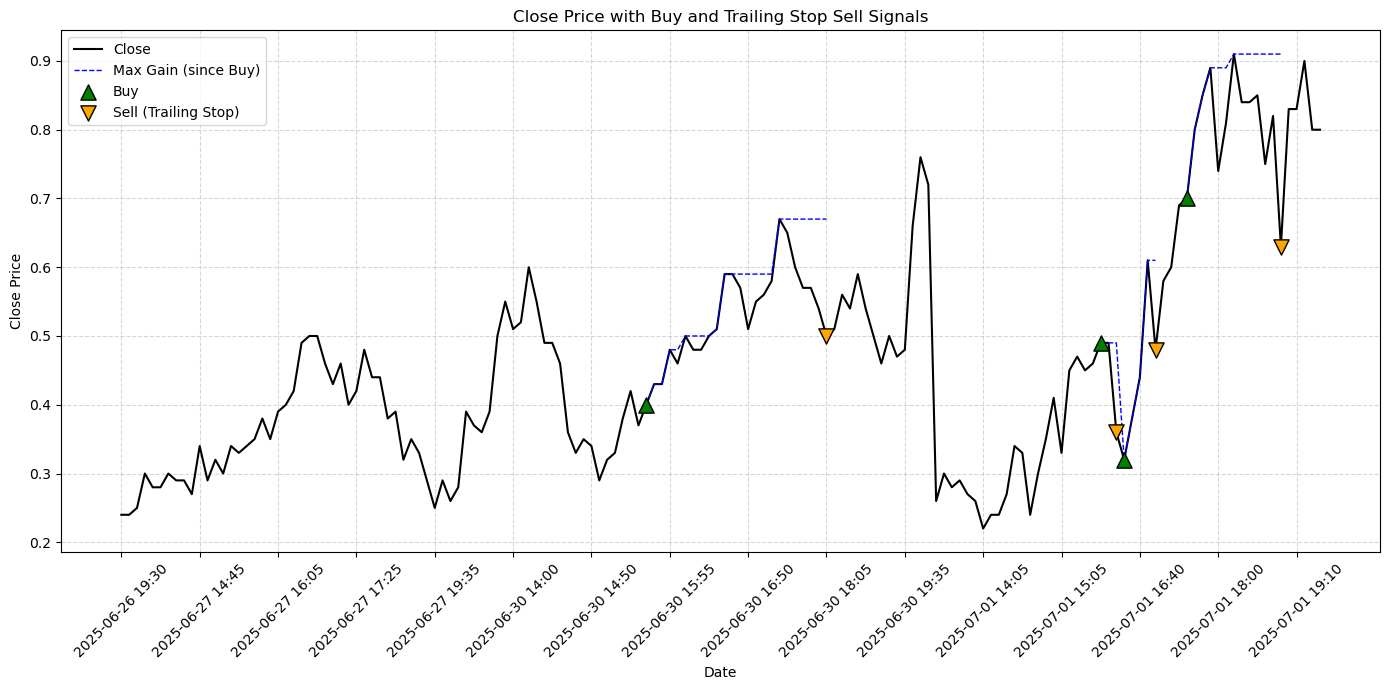

In [94]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(14, 7))

# Plot the Close price
plt.plot(datafix.index, datafix["Close"], label="Close", color="black", linewidth=1.5)

# (Optional) Plot the running max_gain as a blue dashed line
plt.plot(datafix.index, datafix["max_gain"], label="Max Gain (since Buy)", color="blue", linestyle="dashed", linewidth=1)

# Plot buy signals (green upward triangle)
buy_signals = datafix[datafix["Signal"] == "buy"]
plt.scatter(buy_signals.index, buy_signals["Close"], marker="^", color="green", edgecolor="black", s=120, label="Buy", zorder=3)

# Plot sell signals (orange downward triangle)
sell_signals = datafix[datafix["Signal"] == "sell"]
plt.scatter(sell_signals.index, sell_signals["Close"], marker="v", color="orange", edgecolor="black", s=120, label="Sell (Trailing Stop)", zorder=3)

plt.title("Close Price with Buy and Trailing Stop Sell Signals")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend(loc="upper left")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Ensure index is datetime
datafix.index = pd.to_datetime(datafix.index)

# Take every 10th tick
tick_step = 10
tick_locs = np.arange(0, len(datafix.index), tick_step)
tick_labels = [datafix.index[i].strftime('%Y-%m-%d %H:%M') for i in tick_locs]

plt.xticks(tick_locs, tick_labels, rotation=45, fontsize=10)
plt.tight_layout()
plt.show()


In [95]:
import pandas as pd

# Example DataFrame (replace with your actual data)
backdata = pd.DataFrame({
    "Signal": datafix["Signal"],   # "buy" or "sell"
    "close": datafix["Close"],
})

# Initialize columns
backdata['Return'] = 0.0

# Track position and entry price
position = None
entry_price = None

for idx, row in backdata.iterrows():
    if row['Signal'] == 'buy' and position is None:
        # Enter long position
        position = 'long'
        entry_price = row['close']
        backdata.at[idx, 'Return'] = 0.0
    elif position == 'long':
        # While in position, show running return
        backdata.at[idx, 'Return'] = row['close'] - entry_price
        if row['Signal'] == 'sell':
            # On sell, close position
            position = None
            entry_price = None
    else:
        # No position, return is zero
        backdata.at[idx, 'Return'] = "None"

# Show the last 50 rows
backdata.tail(50)


/var/folders/f_/1bh6mfq97bxdwzwnr49jf8nm0000gn/T/ipykernel_5520/163779453.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'None' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  backdata.at[idx, 'Return'] = "None"


,Signal,close,Return
Date,,,
2025-07-01 13:30:00,None,0.26,None
2025-07-01 13:35:00,None,0.30,None
2025-07-01 13:40:00,None,0.28,None
2025-07-01 13:50:00,None,0.29,None
2025-07-01 13:55:00,None,0.27,None
2025-07-01 14:00:00,None,0.26,None
2025-07-01 14:05:00,None,0.22,None
2025-07-01 14:10:00,None,0.24,None
2025-07-01 14:15:00,None,0.24,None


In [96]:
import pandas as pd

# Initialize lists to store trade details
buy_indices = []
sell_indices = []
buy_prices = []
sell_prices = []
buy_dates = []
sell_dates = []

in_position = False

for idx, row in datafix.iterrows():
    if not in_position and row["Signal"] == "buy":
        buy_indices.append(idx)
        buy_prices.append(row["Close"])
        buy_dates.append(row.name)
        in_position = True
    elif in_position and row["Signal"] == "sell":
        sell_indices.append(idx)
        sell_prices.append(row["Close"])
        sell_dates.append(row.name)
        in_position = False

# Ensure pairs are matched correctly
pairs = min(len(buy_prices), len(sell_prices))
buy_indices = buy_indices[:pairs]
sell_indices = sell_indices[:pairs]
buy_prices = buy_prices[:pairs]
sell_prices = sell_prices[:pairs]
buy_dates = buy_dates[:pairs]
sell_dates = sell_dates[:pairs]

# Calculate returns for each trade
returns = [(sell - buy) / buy for buy, sell in zip(buy_prices, sell_prices)]

# Create the 'test' DataFrame with trade details and returns
test = pd.DataFrame({
    "Buy_Index": buy_indices,
    "Sell_Index": sell_indices,
    "Buy_Date": buy_dates,
    "Sell_Date": sell_dates,
    "Buy_Price": buy_prices,
    "Sell_Price": sell_prices,
    "Return": returns
})


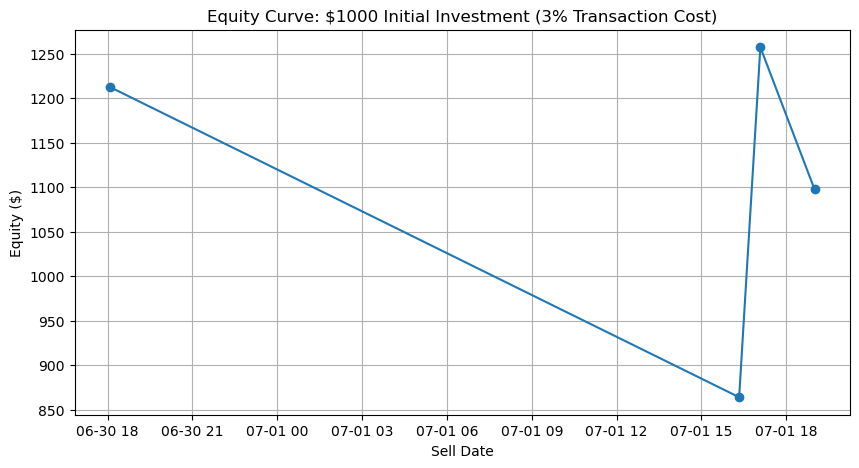

In [97]:
import matplotlib.pyplot as plt

initial_capital = 1000
equity_curve = [initial_capital]

for ret in test["Return"]:
    # Apply 3% transaction cost to each trade
    net_return = (1 + ret) * 0.97  # 3% cost
    equity_curve.append(equity_curve[-1] * net_return)

# Remove the initial capital for plotting (so curve aligns with trades)
equity_curve = equity_curve[1:]
test["Equity"] = equity_curve

plt.figure(figsize=(10,5))
plt.plot(test["Sell_Date"], test["Equity"], marker='o')
plt.title("Equity Curve: $1000 Initial Investment (3% Transaction Cost)")
plt.xlabel("Sell Date")
plt.ylabel("Equity ($)")
plt.grid(True)
plt.show()


In [98]:
from IPython.display import display, HTML

# Display last 30 rows in a scrollable box
display(HTML(datafix.to_html(max_rows=50, max_cols=60, notebook=True, border=1,
    table_id="scrollable-table", classes="scrollable-table")))

# Add scrollable CSS (run once per notebook)
display(HTML("""
<style>
.scrollable-table {
    display: block;
    max-height: 400px;
    overflow-y: scroll;
    width: fit-content;
    border: 1px solid #ccc;
}
</style>
"""))


,Open,High,Low,Close,Volume,Kalman,Kalman_Roc,MACD,Signal,MACD_Hist,days_to_expiry,stock price,strike,rfr,type,IV,IVROC,MACD_Hist_std,regime_state,IV_garch_vol,GarchRoc,GarchRoc5sma,GarchSma,GarchSmaSpread,regimecount,GarchSmaSpread_std,GarchRocsma_std,GarchRoc_std,RSI,rsiMA_14,MACDvol,Signalvol,MACD_Histvol,MACDROCvol,MACDkalman,Signalkalman,MACD_Histkalman,MACDROCkal,MACDROC,VolumeSMA9,VolumeSMA26,Kalman_Roc_roll,MACDROCvolroll9,MACDROCkalroll9,stocktrend,sma30,smaspread,IV_garch_volsma,kalmansma,max_gain,AvgVol
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-06-26 19:30:00,0.24,0.24,0.24,0.24,1,0.240000,NaN,0.000000,None,0.000000,7.0,345.770,360,0.0429,c,0.184933,NaN,NaN,NaN,0.174735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000e+00,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-06-26 19:35:00,0.24,0.24,0.24,0.24,1,0.240000,0.000000,0.000000,None,0.000000,7.0,346.090,360,0.0429,c,0.181526,-1.842049,NaN,0.0,0.180450,0.032706,NaN,NaN,NaN,NaN,NaN,NaN,1.231093,NaN,NaN,0.000456,0.000091,3.647105e-04,inf,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-06-26 19:40:00,0.25,0.25,0.25,0.25,1,0.248120,3.383141,0.000798,None,0.000638,7.0,346.000,360,0.0429,c,0.184139,1.439518,NaN,0.0,0.181495,0.005793,NaN,NaN,NaN,NaN,NaN,NaN,0.186551,NaN,NaN,0.000891,0.000251,6.400679e-04,0.755003,0.000648,0.000130,0.000518,inf,inf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-06-27 13:40:00,0.26,0.30,0.26,0.30,3,0.285757,15.169284,0.005402,None,0.004194,6.0,347.000,360,0.0429,c,0.195860,6.364949,NaN,0.0,0.183240,0.009614,0.016038,NaN,NaN,NaN,NaN,1.025877,0.334842,NaN,NaN,0.001361,0.000473,8.881675e-04,0.387615,0.004150,0.000934,0.003217,5.207560,5.572080,NaN,NaN,NaN,NaN,NaN,1.185199e-03,NaN,NaN,NaN,NaN,NaN,NaN
2025-06-27 13:50:00,0.29,0.29,0.28,0.28,2,0.289558,1.329912,0.007353,None,0.004916,6.0,348.340,360,0.0429,c,0.176703,-9.780990,NaN,0.0,0.189745,0.035498,0.016968,NaN,NaN,NaN,NaN,1.088939,1.339450,NaN,NaN,0.002233,0.000825,1.407908e-03,0.585183,0.007150,0.002177,0.004973,0.546142,0.172045,NaN,NaN,NaN,NaN,NaN,2.163932e-03,NaN,NaN,NaN,NaN,NaN,NaN
2025-06-27 14:00:00,0.32,0.32,0.28,0.28,5,0.290754,0.413225,0.008797,None,0.005088,6.0,348.820,360,0.0429,c,0.170920,-3.272738,NaN,0.0,0.183757,-0.031554,0.004519,NaN,NaN,NaN,NaN,0.245340,-1.262975,NaN,NaN,0.002413,0.001143,1.270253e-03,-0.097773,0.009515,0.003645,0.005870,0.180338,0.035064,NaN,NaN,NaN,NaN,NaN,2.709936e-03,NaN,NaN,NaN,0.040591,NaN,NaN
2025-06-27 14:05:00,0.30,0.30,0.30,0.30,1,0.300598,3.385509,0.011424,None,0.006172,6.0,349.250,360,0.0429,c,0.168579,-1.369595,NaN,0.0,0.178150,-0.030513,-0.008857,NaN,NaN,NaN,NaN,-0.661054,-1.222583,NaN,NaN,0.002079,0.001330,7.491362e-04,-0.410246,0.012044,0.005324,0.006720,0.144695,0.213016,NaN,NaN,NaN,NaN,NaN,2.157454e-03,NaN,NaN,NaN,0.047362,NaN,NaN
2025-06-27 14:10:00,0.34,0.34,0.29,0.29,4,0.301603,0.334262,0.012554,None,0.005842,6.0,348.690,360,0.0429,c,0.173971,3.198674,NaN,0.0,0.174317,-0.021517,-0.027862,NaN,NaN,NaN,NaN,-1.948906,-0.873420,NaN,NaN,0.001488,0.001362,1.264824e-04,-0.831162,0.013968,0.007053,0.006915,0.029125,-0.053511,NaN,NaN,NaN,NaN,NaN,3.357519e-04,NaN,NaN,NaN,0.041264,NaN,NaN
2025-06-27 14:15:00,0.29,0.29,0.29,0.29,1,0.301822,0.072742,0.013296,None,0.005267,6.0,348.180,360,0.0429,c,0.180140,3.545910,NaN,0.0,0.174981,0.003812,-0.016073,NaN,NaN,NaN,NaN,-1.150059,0.109656,NaN,NaN,0.001061,0.001302,-2.404232e-04,-2.900844,0.015335,0.008710,0.006625,-0.041957,-0.098333,2.111111,NaN,NaN,NaN,NaN,-6.111086e-04,NaN,NaN,NaN,0.011071,NaN,NaN


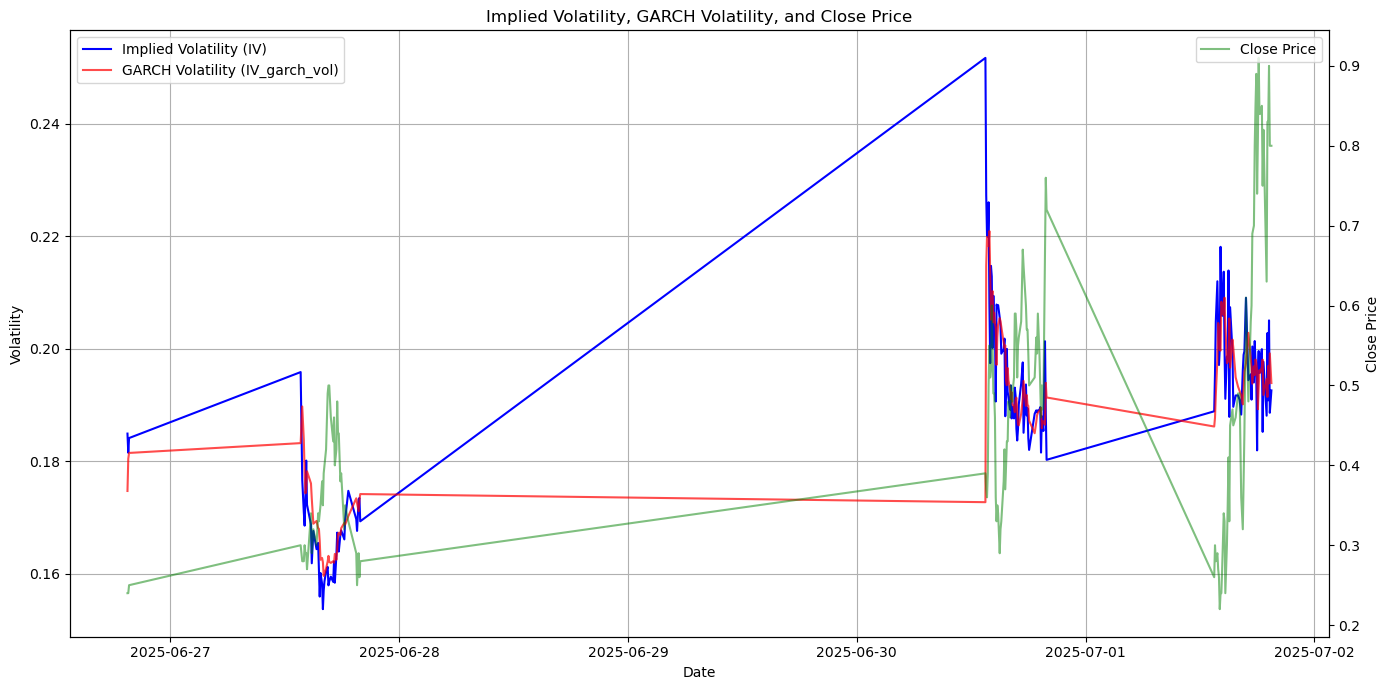

In [99]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot IV and IV_garch_vol on the left y-axis
ax1.plot(datafix.index, datafix['IV'], label='Implied Volatility (IV)', color='blue')
ax1.plot(datafix.index, datafix['IV_garch_vol'], label='GARCH Volatility (IV_garch_vol)', color='red', alpha=0.7)
ax1.set_xlabel('Date')
ax1.set_ylabel('Volatility')
ax1.legend(loc='upper left')
ax1.grid(True)

# Create a second y-axis for the close price
ax2 = ax1.twinx()
ax2.plot(datafix.index, datafix['Close'], label='Close Price', color='green', alpha=0.5)
ax2.set_ylabel('Close Price')
ax2.legend(loc='upper right')

plt.title('Implied Volatility, GARCH Volatility, and Close Price')
plt.tight_layout()
plt.show()


In [100]:
"""import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot standardized GARCH SMA spread (left y-axis)
ax1.plot(datafix.index, datafix['GarchSmaSpread_std'], label='Standardized GARCH SMA Spread', color='purple')
ax1.set_ylabel('Standardized GARCH SMA Spread', color='purple')
ax1.tick_params(axis='y', labelcolor='purple')

# Plot IV on the first secondary y-axis
ax2 = ax1.twinx()
ax2.plot(datafix.index, datafix['IV'], label='Implied Volatility (IV)', color='blue', alpha=0.7)
ax2.set_ylabel('Implied Volatility (IV)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Plot Close on the second secondary y-axis, offsetting the axis
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("axes", 1.1))  # Offset the third y-axis
ax3.plot(datafix.index, datafix['Close'], label='Close Price', color='green', alpha=0.5)
ax3.set_ylabel('Close Price', color='green')
ax3.tick_params(axis='y', labelcolor='green')

# Add title and grid
plt.title('Standardized GARCH SMA Spread vs. IV and Close Price')
ax1.grid(True)
fig.tight_layout()  # Adjust layout to prevent label overlap

plt.show()"""


'import matplotlib.pyplot as plt\n\nfig, ax1 = plt.subplots(figsize=(14, 7))\n\n# Plot standardized GARCH SMA spread (left y-axis)\nax1.plot(datafix.index, datafix[\'GarchSmaSpread_std\'], label=\'Standardized GARCH SMA Spread\', color=\'purple\')\nax1.set_ylabel(\'Standardized GARCH SMA Spread\', color=\'purple\')\nax1.tick_params(axis=\'y\', labelcolor=\'purple\')\n\n# Plot IV on the first secondary y-axis\nax2 = ax1.twinx()\nax2.plot(datafix.index, datafix[\'IV\'], label=\'Implied Volatility (IV)\', color=\'blue\', alpha=0.7)\nax2.set_ylabel(\'Implied Volatility (IV)\', color=\'blue\')\nax2.tick_params(axis=\'y\', labelcolor=\'blue\')\n\n# Plot Close on the second secondary y-axis, offsetting the axis\nax3 = ax1.twinx()\nax3.spines["right"].set_position(("axes", 1.1))  # Offset the third y-axis\nax3.plot(datafix.index, datafix[\'Close\'], label=\'Close Price\', color=\'green\', alpha=0.5)\nax3.set_ylabel(\'Close Price\', color=\'green\')\nax3.tick_params(axis=\'y\', labelcolor=\'gre

In [ ]:
datafix

,Open,High,Low,Close,Volume,Kalman,Kalman_Roc,MACD,Signal,MACD_Hist,...,Kalman_Roc_roll,MACDROCvolroll9,MACDROCkalroll9,stocktrend,sma30,smaspread,IV_garch_volsma,kalmansma,max_gain,AvgVol
Date,,,,,,,,,,,,,,,,,,,,,
2025-06-26 19:30:00,0.24,0.24,0.24,0.24,1,0.240000,NaN,0.000000,None,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-06-26 19:35:00,0.24,0.24,0.24,0.24,1,0.240000,0.000000,0.000000,None,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-06-26 19:40:00,0.25,0.25,0.25,0.25,1,0.248120,3.383141,0.000798,None,0.000638,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-06-27 13:40:00,0.26,0.30,0.26,0.30,3,0.285757,15.169284,0.005402,None,0.004194,...,NaN,NaN,NaN,0.001185,NaN,NaN,NaN,NaN,NaN,NaN
2025-06-27 13:50:00,0.29,0.29,0.28,0.28,2,0.289558,1.329912,0.007353,None,0.004916,...,NaN,NaN,NaN,0.002164,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-01 19:05:00,0.74,0.83,0.74,0.83,12,0.826370,1.505317,0.081671,None,-0.013067,...,0.463937,0.566577,-0.259668,-0.000252,0.7330,-0.0970,-0.001566,-0.011358,NaN,9.95
2025-07-01 19:10:00,0.85,0.85,0.80,0.83,3,0.835451,1.098936,0.080639,None,-0.011280,...,0.315415,-1.740432,-1.058966,0.000244,0.7525,-0.0775,-0.001477,-0.011041,NaN,9.50
2025-07-01 19:15:00,0.85,0.90,0.82,0.90,16,0.860550,3.004267,0.084495,None,-0.005939,...,0.095465,-1.670640,-1.000415,0.000487,0.7670,-0.1330,-0.001136,-0.000271,NaN,9.75
